In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('/kaggle/input/traffic-collisions-toronto/Traffic_Collisions_Toronto_data.csv')

/kaggle/input/traffic-collisions-toronto/Traffic_Collisions_Toronto_data.csv


**PART 1. CLEANING AND PREPARING THE DATASET**

In [2]:
df.head()

,X,Y,OBJECTID,EventUniqueId,OccurrenceDate,Month,Day_of_Week,Year,Hour,Division,Atom,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Longitude,Latitude,ObjectId2
0,0.0,0.0,1,GO-20141001,2014/02/07 05:00:00+00,February,Friday,2014,16,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,1
1,0.0,0.0,2,GO-20141225593,2014/01/02 05:00:00+00,January,Thursday,2014,3,NSA,NSA,NSA,0,NO,YES,NO,0.0,0.0,2
2,0.0,0.0,3,GO-20141260499,2014/01/01 05:00:00+00,January,Wednesday,2014,2,NSA,NSA,NSA,0,YES,NO,NO,0.0,0.0,3
3,0.0,0.0,4,GO-20141260663,2014/01/01 05:00:00+00,January,Wednesday,2014,3,NSA,NSA,NSA,0,NO,NO,YES,0.0,0.0,4
4,0.0,0.0,5,GO-20141261162,2014/01/01 05:00:00+00,January,Wednesday,2014,5,NSA,NSA,NSA,0,YES,NO,NO,0.0,0.0,5


In [3]:
df.dtypes

X                    float64
Y                    float64
OBJECTID               int64
EventUniqueId         object
OccurrenceDate        object
Month                 object
Day_of_Week           object
Year                   int64
Hour                   int64
Division              object
Atom                  object
Neighbourhood         object
Fatalities             int64
Injury_Collisions     object
FTR_Collisions        object
PD_Collisions         object
Longitude            float64
Latitude             float64
ObjectId2              int64
dtype: object

We will have some data that we want to reprocess. From metadata we know that:
1. **OBJECTID** and **ObjectId2** are essentially duplicates, and are index columns. We will drop those, and create a new index
2. **OccurenceDate** -- we will change this to datetime type
3. Once we have **OccurenceDate** as datetime we will see whether we need to keep separately columns for **Month**, **Year**, **Hour**
4. For computational efficiencies we will change to category types columns **Division**, **Atom** and **Neighbourhood** after cleaning them from missing data
5. Columns **Injury_Collisions**, **FTR_Collisions**, **PD_Collisions** should be converted to boolean

In [4]:
df.shape
## Our data has 499 538 observations (and 19 columns)

(499538, 19)

In [5]:
## Let's drop columns we won't use:
df_clean = df.drop(['OBJECTID','ObjectId2'], axis=1)

## We don't have any data explicitely marked as 'NaN', but that could be how our data is marked
print(df_clean.isna().sum())

## Let's convert OccurrenceDate column to datetime. 
df_clean['OccurrenceDate'] = pd.to_datetime(df['OccurrenceDate'], yearfirst=True)

## We will convert Division, Atom and Neighbourhood into categorical variables, but before let's explore them:
print(df_clean['Division'].unique())
print(df_clean['Atom'].unique())

## We can see that we have 'NSA' values:
## We have observations where Neighborhood ID (Atom) is missing, but Police division is present:
print(df_clean[df_clean['Atom']=='NSA'].groupby(['Division']).aggregate({'EventUniqueId':'count'}))

## We also have observations wher Police division is 'NSA', but Neighbourhood ID is present:
print(df_clean[df_clean['Division']=='NSA'].groupby(['Atom']).aggregate({'EventUniqueId':'count'}))

X                    0
Y                    0
EventUniqueId        0
OccurrenceDate       0
Month                0
Day_of_Week          0
Year                 0
Hour                 0
Division             0
Atom                 0
Neighbourhood        0
Fatalities           0
Injury_Collisions    0
FTR_Collisions       0
PD_Collisions        0
Longitude            0
Latitude             0
dtype: int64
['NSA' 'D54/D55' 'D43' 'D41' 'D11' 'D31' 'D32' 'D14' 'D53' 'D12' 'D33'
 'D42' 'D23' 'D22' 'D52' 'D13' 'D51']
['NSA' '40' '531' '25' '27' '31' '48' '119' '76' '134' '117' '128' '14'
 '136' '23' '34' '49' '21' '39' '139' '127' '124' '120' '122' '75' '47'
 '24' '137' '35' '131' '133' '123' '88' '1' '103' '45' '105' '140' '135'
 '132' '138' '129' '130' '125' '126' '121' '63' '62' '61' '118' '54' '43'
 '70' '116' '60' '64' '66' '65' '59' '58' '53' '44' '42' '46' '69' '55'
 '68' '67' '77' '57' '73' '41' '72' '56' '71' '52' '98' '74' '99' '95'
 '78' '104' '51' '79' '97' '50' '82' '100' '96' '101'

In [6]:
## Since this is not a significant portion of observations, and each Division is reponsible for multiple neighborhoods, we will drop all NSA values:
NSA_selector = (df_clean['Division']=='NSA') | (df_clean['Atom']=='NSA') | (df_clean['Neighbourhood']=='NSA')

df_clean = df_clean[~NSA_selector]

## After dropping, we have 426 811 observations (vs 499 538) -- we've dropped 15% of rows
print(df_clean.shape)

(426811, 17)


In [7]:
## Now let's convert to category type: this will improve performace and computational efficiency
df_clean['Division'] = df_clean.Division.astype('category')
df_clean['Atom'] = df_clean.Atom.astype('category')
df_clean['Neighbourhood'] = df_clean.Neighbourhood.astype('category')
print(df_clean.dtypes)

## Now we convert Injury_Collisions, FTR_Collisions, PD_Collisions should be converted to boolean
boolean_columns = ['Injury_Collisions','FTR_Collisions','PD_Collisions']

for i in boolean_columns:
    df_clean[i] = df_clean[i].map({'YES': True, 'NO': False})

X                                float64
Y                                float64
EventUniqueId                     object
OccurrenceDate       datetime64[ns, UTC]
Month                             object
Day_of_Week                       object
Year                               int64
Hour                               int64
Division                        category
Atom                            category
Neighbourhood                   category
Fatalities                         int64
Injury_Collisions                 object
FTR_Collisions                    object
PD_Collisions                     object
Longitude                        float64
Latitude                         float64
dtype: object


In [8]:
print(df_clean.dtypes)

X                                float64
Y                                float64
EventUniqueId                     object
OccurrenceDate       datetime64[ns, UTC]
Month                             object
Day_of_Week                       object
Year                               int64
Hour                               int64
Division                        category
Atom                            category
Neighbourhood                   category
Fatalities                         int64
Injury_Collisions                   bool
FTR_Collisions                      bool
PD_Collisions                       bool
Longitude                        float64
Latitude                         float64
dtype: object


**PART 2. EXPLORING THE CLEAN DATASET**

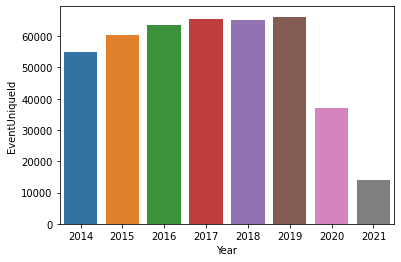

In [9]:
## Let's do some EDA now
import matplotlib.pyplot as plt
import seaborn as sns

# First of all let's try to have a look at overall collisions by year

by_year = df_clean.groupby('Year').aggregate({'EventUniqueId':'count'})
sns.barplot(x=by_year.index,y='EventUniqueId',data=by_year)
plt.show()
## We can see that collisions by year were growing until 2019 when they rapidly dropped in 2020 and 2021 -- during the COVID pandemics